In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from networkx.drawing.nx_pydot import write_dot
from networkx.linalg.graphmatrix import *
from networkx.algorithms.approximation import *
#from networkx.centrality import closn
from networkx.algorithms import *
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import OneHotEncoder
import gc
gc.collect()

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV

In [2]:
import sys
import os
module_path = os.path.abspath('C:\\Users\\Matteo\\Documents\\work in progress\\GRAPH_NN\\XaiGraph')
if module_path not in sys.path:
    sys.path.append(module_path)

# DATA LOADING AND PREPROCESSING

In [3]:
from datasets.titanic_cooking import titanic_cooking

X_train_prepro, X_test_prepro = titanic_cooking()

TRAIN
    age  count
0  0.85    128
1  0.15    119
2  0.55    117
3  0.45    109
4  0.75    106
5  0.25    102
6  0.35    101
7  0.05     96
8  0.65     90
9  0.95     79
TEST
    age  count
0  0.85     36
1  0.55     30
2  0.35     28
3  0.75     28
4  0.25     26
5  0.65     24
6  0.95     24
7  0.05     23
8  0.45     23
9  0.15     20
TRAIN
   fare  count
0  0.15    199
1  0.65    145
2  0.85    145
3  0.25    123
4  0.35     97
5  0.45     89
6  0.75     86
7  0.55     83
8  0.95     55
9  0.05     25
TEST
   fare  count
0  0.65     47
1  0.15     44
2  0.85     43
3  0.45     24
4  0.25     23
5  0.55     23
6  0.75     21
7  0.95     16
8  0.35     13
9  0.05      8
TRAIN
   family_size  count
0          0.0    643
1          1.0    178
2          2.0    123
3          3.0     35
4          4.0     20
5          5.0     20
6          6.0     15
7         10.0      7
8          7.0      6
TEST
   family_size  count
0          0.0    147
1          1.0     57
2          2.0     36

C:\Users\Matteo\matteo_virtualenv\graph_nn\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\Matteo\Documents\work in progress\GRAPH_NN\XaiGraph\datasets\titanic_cooking.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['family_size'] = dataset['parch'] + dataset['sibsp']
C:\Users\Matteo\Documents\work in progress\GRAPH_NN\XaiGraph\datasets\titanic_cooking.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

# MODEL

Feature preprocessing for model

In [4]:
# Train
cont = X_train_prepro[['age', 'fare']].values
cat = X_train_prepro[['family_size', 'embarked', 'sex', 'pclass', 'title', 'is_alone']].values
tar = X_train_prepro[['target']].values

# Test
cont_test = X_test_prepro[['age', 'fare']].values
cat_test = X_test_prepro[['family_size', 'embarked', 'sex', 'pclass', 'title', 'is_alone']].values
tar_test = X_test_prepro[['target']].values

In [5]:
# Categorical variables: OHE
enc = OneHotEncoder()
enc.fit(cat)
cat_enc = enc.transform(cat)
cat_test_enc = enc.transform(cat_test)

# Build the name of the dummy variables
enc_names = ['age', 'fare']
col_n = 'family_size'
for v in pd.unique(X_train_prepro[col_n]):
    enc_names.append(col_n + '_{:.1f}'.format(v))
col_n = 'embarked'
for v in pd.unique(X_train_prepro[col_n]):
    enc_names.append(col_n + '_{}'.format(v))
col_n = 'sex'
for v in pd.unique(X_train_prepro[col_n]):
    enc_names.append(col_n + '_{}'.format(v))
col_n = 'pclass'
for v in pd.unique(X_train_prepro[col_n]):
    enc_names.append(col_n + '_{:.1f}'.format(v))   
col_n = 'title'
for v in pd.unique(X_train_prepro[col_n]):
    enc_names.append(col_n + '_{}'.format(v))
col_n = 'is_alone'
for v in pd.unique(X_train_prepro[col_n]):
    enc_names.append(col_n + '_{:.1f}'.format(v))   
enc_names.append('target')

# Re-build the feature dataframe using dummy variables
data = np.concatenate((cont, cat_enc.toarray(), tar), axis=1)
model_train_df = pd.DataFrame(data, columns=enc_names)
data = np.concatenate((cont_test, cat_test_enc.toarray(), tar_test), axis=1)
model_test_df = pd.DataFrame(data, columns=enc_names)
model_train_df

,age,fare,family_size_0.0,family_size_1.0,family_size_6.0,family_size_2.0,family_size_5.0,family_size_4.0,family_size_7.0,family_size_3.0,...,pclass_3.0,pclass_2.0,pclass_1.0,title_Mrs,title_Mr,title_Master,title_rare,is_alone_1.0,is_alone_0.0,target
0,0.75,0.15,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
1,0.35,0.65,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
2,0.05,0.75,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.35,0.15,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.15,0.15,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042,0.85,0.15,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
1043,0.05,0.75,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1044,0.15,0.25,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1045,0.15,0.35,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [6]:
# Train-Test a model 
from sklearn.metrics import accuracy_score
model = RandomForestClassifier()
model.fit(model_train_df.drop(['target'], axis=1).values, model_train_df['target'].values)
train_predict = model.predict_proba(model_train_df.drop(['target'], axis=1).values)
test_predict = model.predict_proba(model_test_df.drop(['target'], axis=1).values)
train_predict_acc = model.predict(model_train_df.drop(['target'], axis=1).values)
test_predict_acc = model.predict(model_test_df.drop(['target'], axis=1).values)

print('TRAIN ACCURACY: {:.4f}'.format(accuracy_score(model_train_df['target'].values, train_predict_acc)))
print('TEST ACCURACY: {:.4f}'.format(accuracy_score(model_test_df['target'].values, test_predict_acc)))

TRAIN ACCURACY: 0.8997
TEST ACCURACY: 0.7786


Using the score of the model as a new column target, compute the PageRank importance for class 1 and class 0.

NOTE: In order to reduce noise, the graph of class 1 is built taking into account only rows where model score is in top 30% and, in the same way, the graph of class 0 is built using rows where the model score is in the last 30%

In [7]:
tmp = X_train_prepro.drop(['target'], axis=1)
tmp['target'] = train_predict_acc  #train_predict[:, 1]
up_value = 0.65
down_value = 1 - up_value
up_limit = np.quantile(tmp['target'].values, up_value, axis=0)
down_limit = np.quantile(tmp['target'].values, down_value, axis=0)
#imp_t1_model_train, _, _ = target_importance(tmp, 'greater_or_equal_than', up_limit, true_weights=None)
#imp_t0_model_train, _, _ = target_importance(tmp, 'less_or_equal_than', down_limit,  true_weights=None)

In [8]:
tmp

,age,fare,family_size,embarked,sex,pclass,title,is_alone,target
0,0.75,0.15,0.0,Q,female,3.0,Mrs,1,1.0
1,0.35,0.65,1.0,C,female,2.0,Mrs,1,1.0
2,0.05,0.75,6.0,S,female,3.0,Mrs,0,0.0
3,0.35,0.15,0.0,C,male,3.0,Mr,1,0.0
4,0.15,0.15,0.0,S,female,3.0,Mrs,1,1.0
...,...,...,...,...,...,...,...,...,...
1042,0.85,0.15,1.0,S,female,3.0,Mrs,1,1.0
1043,0.05,0.75,5.0,S,male,3.0,Master,0,0.0
1044,0.15,0.25,2.0,S,male,3.0,Mr,0,0.0
1045,0.15,0.35,0.0,S,male,2.0,Mr,1,0.0


# Librería SHAP

In [9]:
from explainers.shap_explainer import ShapExplainer
params = {
    ShapExplainer.MODEL_PREDICT: model.predict,
    ShapExplainer.TARGET_COL: 'target',
    ShapExplainer.OHE: True,
    ShapExplainer.DATAFRAME_WITHOUT_OHE: X_train_prepro,  # sample(n=100, random_state=1, axis=0)
    ShapExplainer.NO_DUMMY_COLS_NUM: 2,
    ShapExplainer.DUMMY_COLS: ['family_size', 'embarked', 'sex', 'pclass', 'title', 'is_alone']
}
explainer = ShapExplainer()
shap_explainer, shap_lib_values = explainer.run(model_train_df, **params)

Permutation explainer: 1048it [05:07,  3.33it/s]                                                                                                                                                                                            


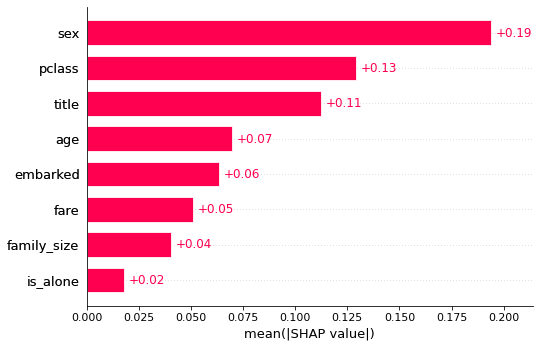

In [10]:
if params[ShapExplainer.MODEL_PREDICT] == model.predict_proba:
    ShapExplainer.plot_shap_global_xai(shap_lib_values[:,:,0])
    ShapExplainer.plot_shap_global_xai(shap_lib_values[:,:,1])
else:
    ShapExplainer.plot_shap_global_xai(shap_lib_values)

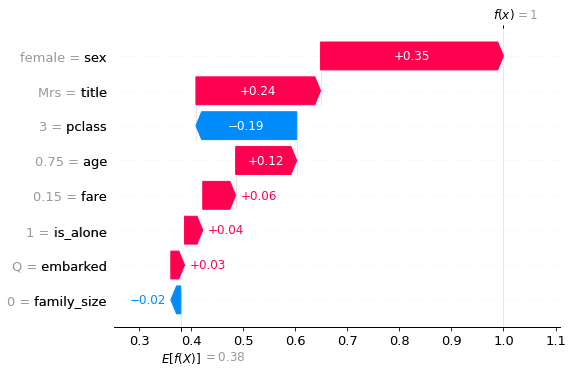

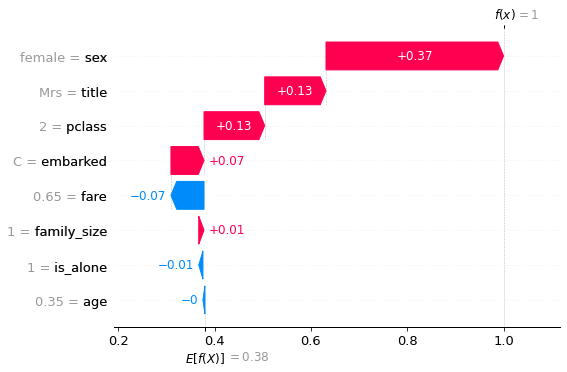

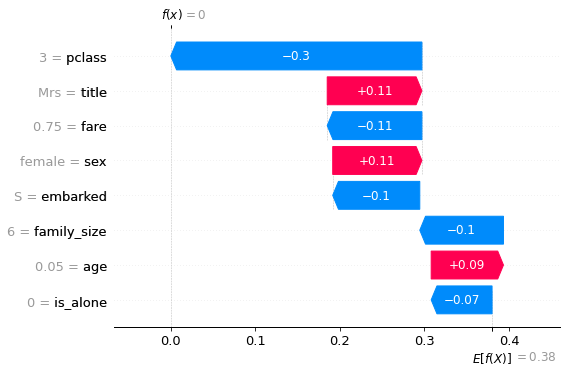

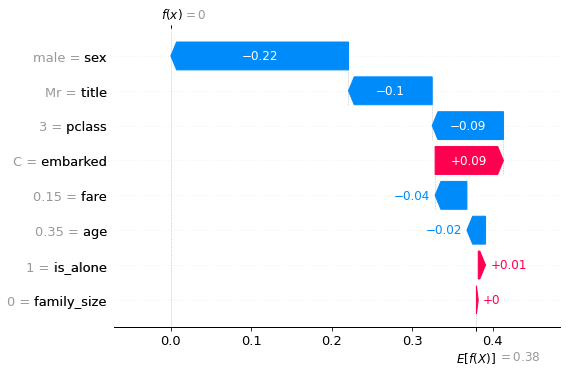

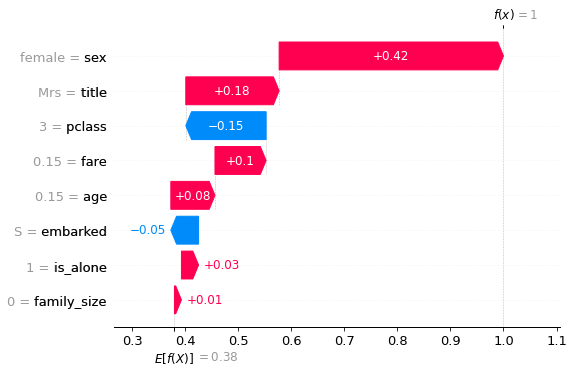

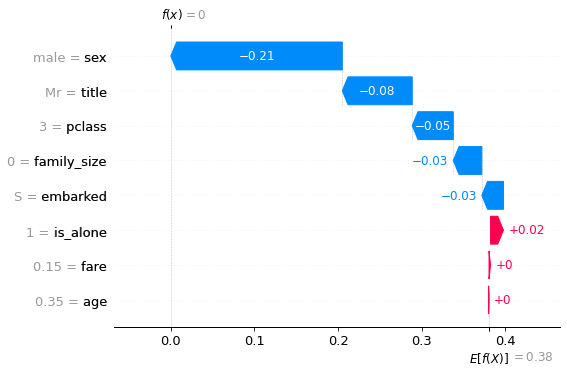

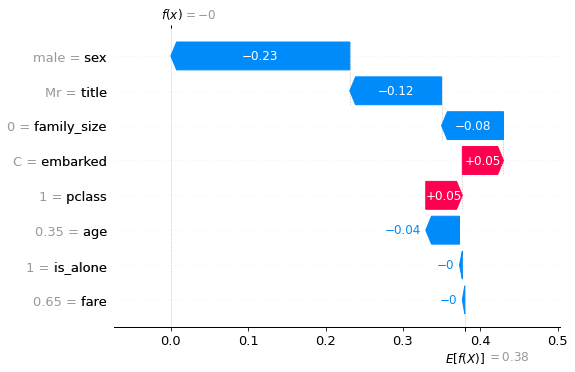

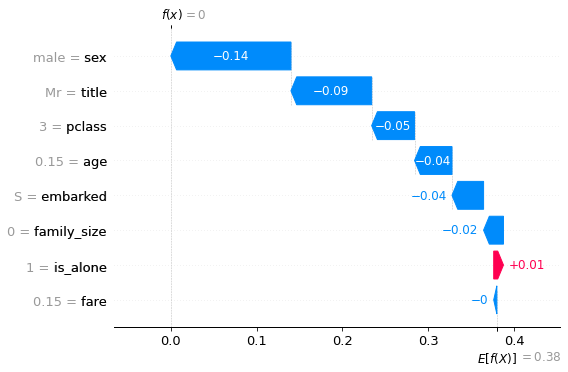

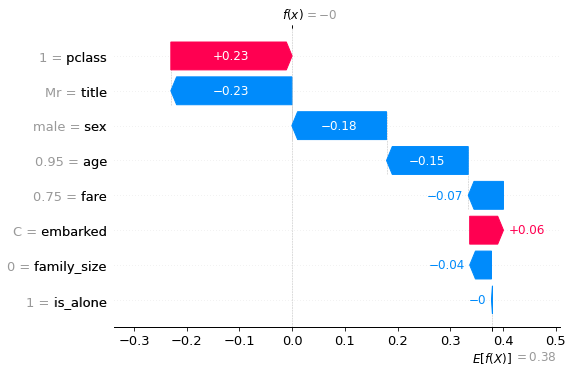

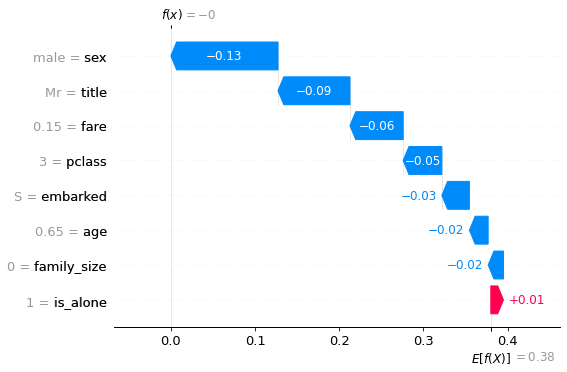

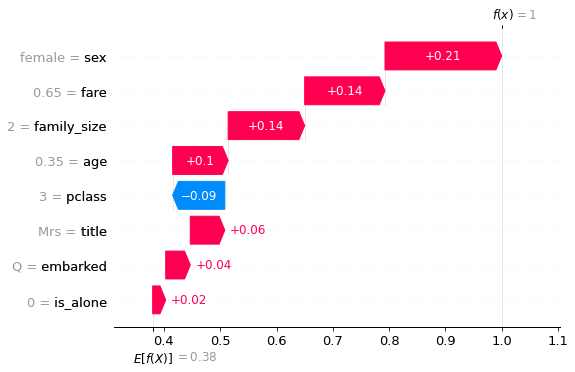

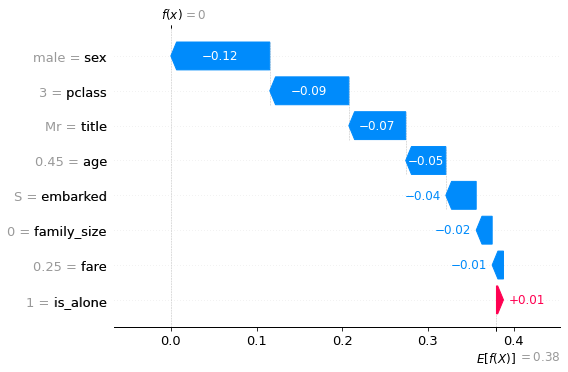

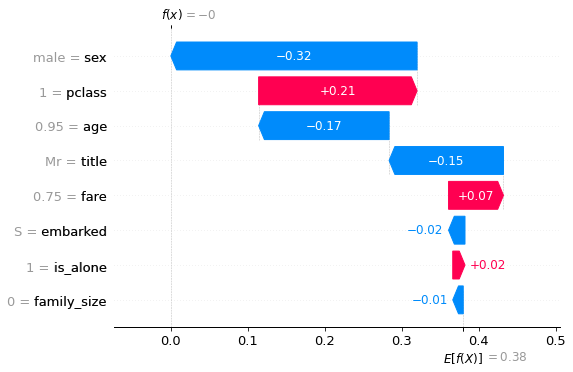

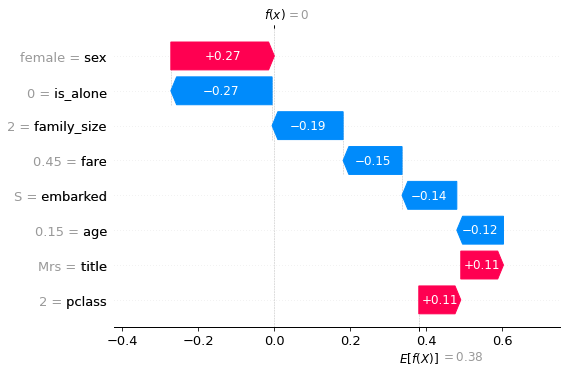

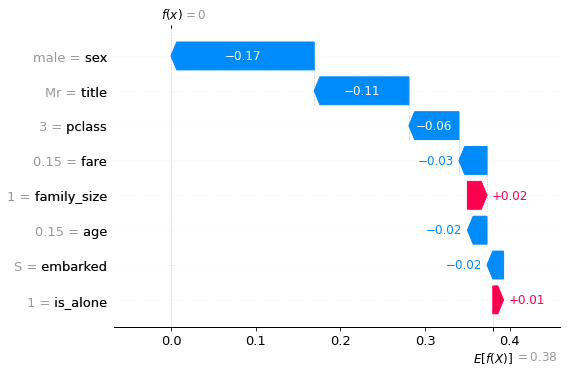

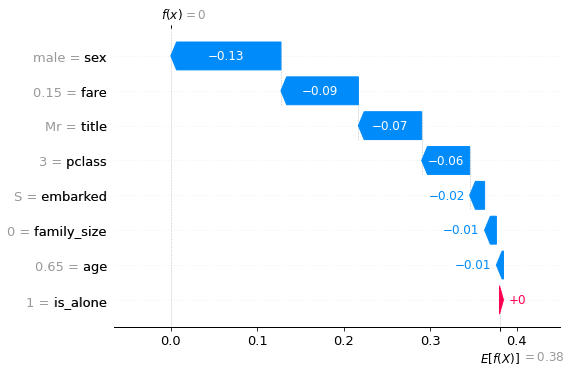

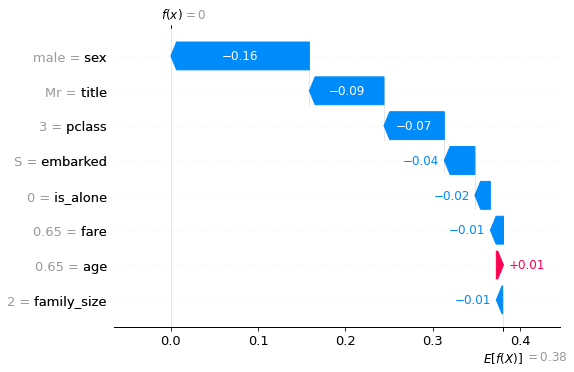

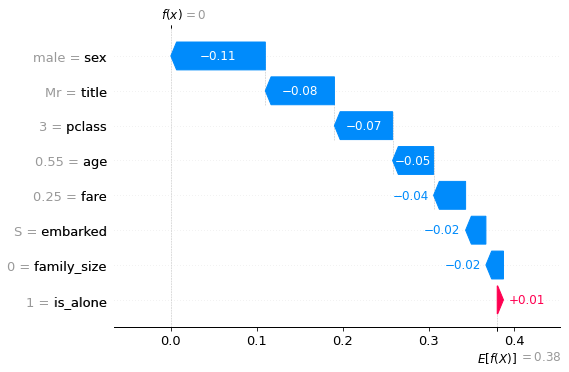

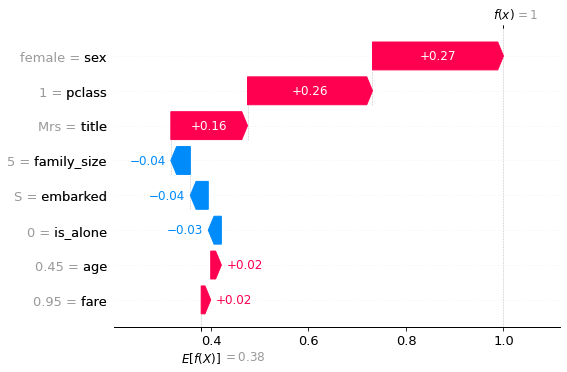

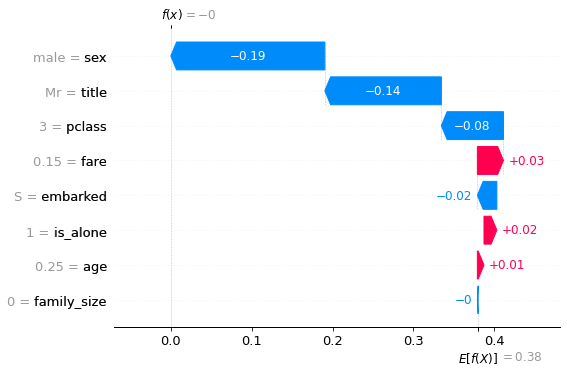

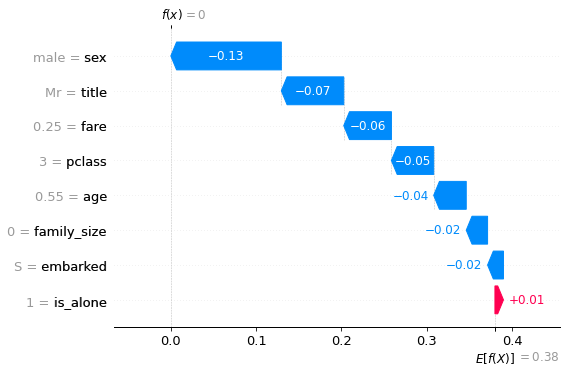

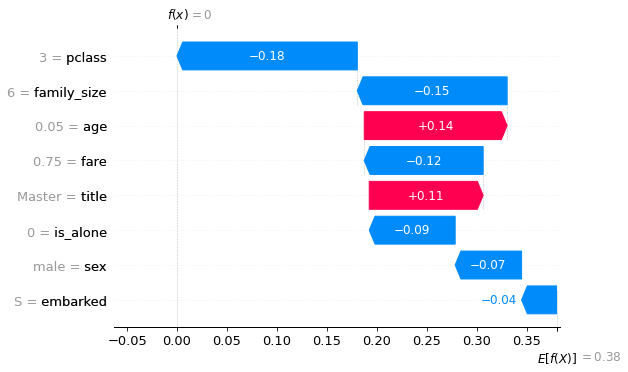

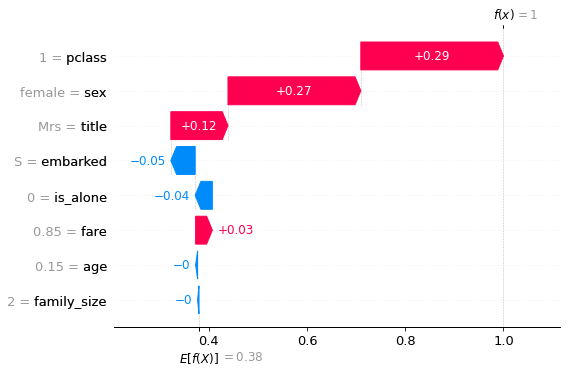

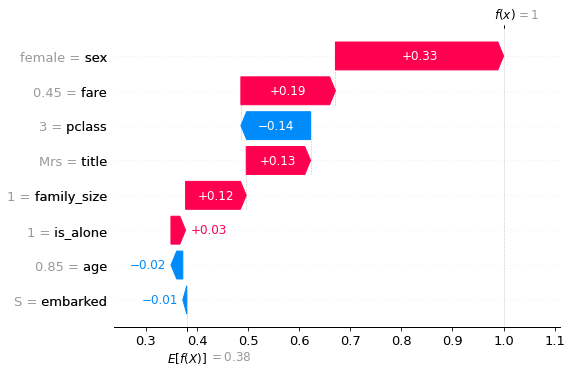

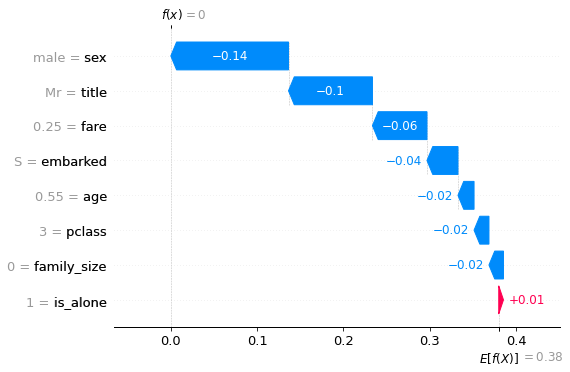

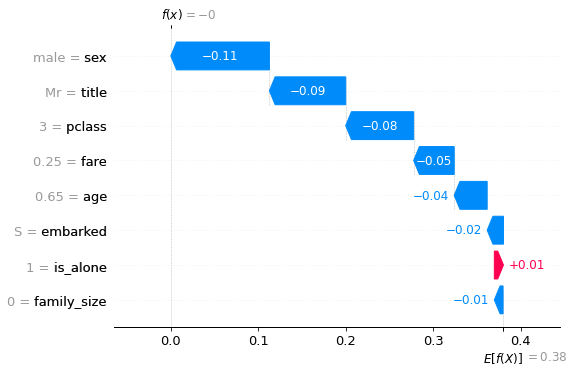

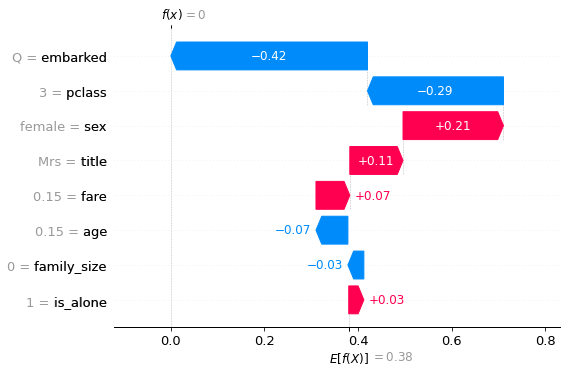

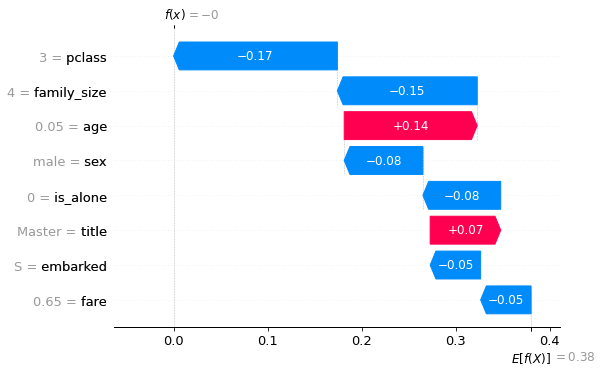

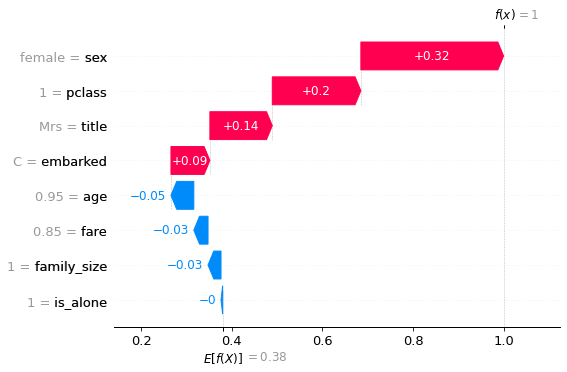

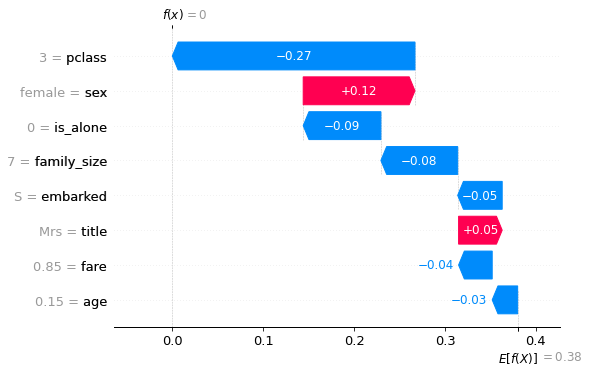

In [11]:
if params[ShapExplainer.MODEL_PREDICT] == model.predict_proba:
    for i in range(30):
        ShapExplainer.plot_shap_local_xai(shap_lib_values[i, :, 1])        
else:
    for i in range(30):
        ShapExplainer.plot_shap_local_xai(shap_lib_values[i])

# TEF SHAP

## REQUISITOS DATASET DE ENTRADA

El dataset de entrada utilizado por el algoritmo de explicabilidad local TEF-SHAP tiene que tener las siguientes caracteristicas:

* **Número de columnas (features)**: Por tema computacional, cuando el número de columnas del dataset es >= 20, es actualmente necesario pre-seleccionar un número de features top_k a priori más relevantes a tener en cuenta para la explicabilidad. El número de variables más relevantes tiene que ser top_k <= 20 (siendo 10 el número recomendado). Se está trabajando sobre posibles implementaciones que no tengan esta limitación computacional, no obstante la versión actual del algoritmo se espera que quien proporciona el dataset (usuario de la librería) se encargue de seleccionar las top_k columnas en base a algún tipo de heuristica previa (por ejemplo estudio de correlación, estudio explicabilidad global, etc.). NOTA: Una vez que se haya determinado en base a alguna heuristica las top_k variables a priori más relevantes, veáse la sección sobre "eliminación de variables menos relevantes" para una guia sobre los pasos a seguir para eliminar del datasets las variables menos relevantes. 
* **Columnas (features) categóricas**: Por construcción, las variables categóricas asumen un número finito y discreto de valores. IMPORTANTE: ¡NO hay que pasar las variables categoricas a One-Hot-Encoding! En el caso en que el dataset original contenga variable OHE, es necesario des-hacer estas variables y recuperar la variable categórica original. NOTA: Es aconsejable que el número de posibles valores de las variables categóricas sea limitado. En los casos de variables categóricas con > 15-20 valores posibles, es aconsejable aplicar algún tipo de trasformación previa para reducir la dimensionalidad de esta variable categórica.  
* **Columnas (features) númericas**: Es necesario discretizar todas las variables númericas. En principio cualquier mecanismo de discretización es válido (Cuantiles, sampling despues de DistFit, reglas de negocio, etc.). Es muy aconsejable por tema computaciónal reducir al máximo el número de valores discretos (<=10 por ejemplo).
* **Columna Target**: El algoritmo se espera una sola columna de target que asuma valores float. Puede ser (0.=False,1.=True) o puede ser cualquier valor continuo. A priori el target no tiene que estar agotado a un rango preciso. IMPORTANTE: El algoritmo de explicación local TEF-SHAP está pensado para problemas de regresión o problema de clasificación binarios. Vease la sección "Explicación multiclasificador" para los pasos a seguir para el caso de querer explicar la predicción de un multiclasificador.

A continuación se muestran varios ejemplos de posibles entrada del algoritmo TEF-SHAP que cumplen con los requisitos anteriormente descritos.

**EJEMPLO 1: Clasificador binario, target=probabilidad**

| Edad    | Revenue| Sexo | id_tarifa | target |
|---------|--------|------|-----------|--------|
| 35      | 100    | H    | 1001      | 0.9    | 
| 45      | 90     | H    | 1002      | 0.3    |
| 60      | 50     | M    | 1003      | 0.1    |
| 30      | 50     | M    | Otros     | 0.77   |

donde:
* La variable continua Edad se ha discretizado redondeando a un múltiplo de 5
* La variable continua Revenue se ha discretizado con 10 cuantiles
* La variable categórica Sexo no se ha tocado
* La variable id_tarifa que asumía > 1000 valores se ha agrupado en N<=20 valores
* Target es una variable entre 0 y 1

**EJEMPLO 2: Clasificador binario, target=clase**

| Edad    | Revenue| Sexo | id_tarifa | target |
|---------|--------|------|-----------|--------|
| 35      | 100    | H    | 1001      | 1      | 
| 45      | 90     | H    | 1002      | 0      |
| 60      | 50     | M    | 1003      | 0      |
| 30      | 50     | M    | Otros     | 1      |

donde:
* La variable continua Edad se ha discretizado redondeando a un múltiplo de 5
* La variable continua Revenue se ha discretizado con 10 cuantiles
* La variable categórica Sexo no se ha tocado
* La variable id_tarifa que asumía > 1000 valores se ha agrupado en N<=20 valores
* Target es una variable binaria (pero en formato float) 

**EJEMPLO 3: Regressión, target=float**

| Edad    | Revenue| Sexo | id_tarifa | target |
|---------|--------|------|-----------|--------|
| 35      | 100    | H    | 1001      | 136    | 
| 45      | 90     | H    | 1002      | 1045   |
| 60      | 50     | M    | 1003      | 39     |
| 30      | 50     | M    | Otros     | -123   |

donde:
* La variable continua Edad se ha discretizado redondeando a un múltiplo de 5
* La variable continua Revenue se ha discretizado con 10 cuantiles
* La variable categórica Sexo no se ha tocado
* La variable id_tarifa que asumía > 1000 valores se ha agrupado en N<=20 valores
* Target es una variable continua (float) 

### Explicación multiclasificador

En el caso de querer aplicar el algoritmo de explicabilidad local TEF-SHAP al caso de un multiclasificador con N clases, es necesario transformar el problema en N problemas binarios, siguiendo los siguientes pasos:

**PREPROCESAMIENTO**
* Seleccionar los top_k <= 20 variables a priori más relevantes. IMPORTANTE: ¡Las mismas top_K variables para todas las N clases que se quieren analizar!
* Discretizar las features continuas
* Preprocesar (si necesario) las features categóricas con > 15-20 niveles

**TRANSFORMAR PROBLEMA MULTICLASE EN N PROBLEMAS BINARIOS**

Podemos distinguir dos casos: 

CASO 1: TARGET=CLASE

Dataset obtenido después del preprocesamiento:

| Edad    | Revenue| Sexo | id_tarifa | target |
|---------|--------|------|-----------|--------|
| 35      | 100    | H    | 1001      | Rojo   | 
| 45      | 90     | H    | 1002      | Verde  |
| 60      | 50     | M    | 1003      | Verde  |
| 30      | 50     | M    | Otros     | Azul   |

N=3 Datsets a usar como entradas del algoritmo TEF-SHAP

| Edad    | Revenue| Sexo | id_tarifa | target=Rojo |
|---------|--------|------|-----------|-------------|
| 35      | 100    | H    | 1001      | 1           | 
| 45      | 90     | H    | 1002      | 0           |
| 60      | 50     | M    | 1003      | 0           |
| 30      | 50     | M    | Otros     | 0           |

| Edad    | Revenue| Sexo | id_tarifa | target=Verde |
|---------|--------|------|-----------|--------------|
| 35      | 100    | H    | 1001      | 0            | 
| 45      | 90     | H    | 1002      | 1            |
| 60      | 50     | M    | 1003      | 1            |
| 30      | 50     | M    | Otros     | 0            |

| Edad    | Revenue| Sexo | id_tarifa | target=Azul |
|---------|--------|------|-----------|-------------|
| 35      | 100    | H    | 1001      | 0           | 
| 45      | 90     | H    | 1002      | 0           |
| 60      | 50     | M    | 1003      | 0           |
| 30      | 50     | M    | Otros     | 1           |

CASO 2: TARGET=ARRAY(PROBABILIDADES)

Dataset obtenido después del preprocesamiento:

| Edad    | Revenue| Sexo | id_tarifa | target=Rojo | target=Verde | target=Azul |
|---------|--------|------|-----------|-------------|--------------|-------------|
| 35      | 100    | H    | 1001      | 0.8         | 0.15         | 0.05        | 
| 45      | 90     | H    | 1002      | 0.2         | 0.6          | 0.2         |
| 60      | 50     | M    | 1003      | 0.3         | 0.68         | 0.02        |
| 30      | 50     | M    | Otros     | 0.1         | 0.4          | 0.5         |

N=3 Datsets a usar como entradas del algoritmo TEF-SHAP

| Edad    | Revenue| Sexo | id_tarifa | target=Rojo |
|---------|--------|------|-----------|-------------|
| 35      | 100    | H    | 1001      | 0.8         | 
| 45      | 90     | H    | 1002      | 0.2         |
| 60      | 50     | M    | 1003      | 0.3         |
| 30      | 50     | M    | Otros     | 0.1         |

| Edad    | Revenue| Sexo | id_tarifa | target=Verde |
|---------|--------|------|-----------|--------------|
| 35      | 100    | H    | 1001      | 0.15         | 
| 45      | 90     | H    | 1002      | 0.6          |
| 60      | 50     | M    | 1003      | 0.68         |
| 30      | 50     | M    | Otros     | 0.4          |

| Edad    | Revenue| Sexo | id_tarifa | target=Azul |
|---------|--------|------|-----------|-------------|
| 35      | 100    | H    | 1001      | 0.05        | 
| 45      | 90     | H    | 1002      | 0.2         |
| 60      | 50     | M    | 1003      | 0.02        |
| 30      | 50     | M    | Otros     | 0.5         |


### Carta a los Reyes Magos: Pipelines

Sería deseable que la librería proporcionara al usuario herramientas para:

* Seleccionar las features a priori más relevantes: Herramienta de explicabilidad global, estudio de correlaciones, etc.
* Discretización de features númericas: cuantiles, distfit+sampleo, reglas de negocio, etc.
* Transformación de features categóricas (necesario para reducir los niveles cuando la cardinalidad de la variable supera 15-20)
* Pipeline: para hilar/automatizar todos los pasos anteriores

### Eliminación de variables menos relevantes

En el caso de un dataset con un número de columnas M >= 20 es actualmente necesario pre-seleccionar un número top_k < 20 (siendo 10 el aconsejable) de columnas a priori más importantes/revelantes. En este caso los pasos a seguir para generar el dataset de entrada del algoritmo son los siguientes: 

**PREPROCESAMIENTO**
* Seleccionar los top_k <= 20 variables a priori más relevantes. IMPORTANTE: ¡Las mismas top_K variables para todas las N clases que se quieren analizar!
* Discretizar las features continuas
* Preprocesar (si necesario) las features categóricas con > 15-20 niveles

**ELIMINAR LAS M-TOP_K FEATURES A PRIORI MENOS RELEVANTES**

A partir del dataset obtenido como salida del preprocesamiento: 

| Edad (top_k) | Revenue (top_k) | Sexo (top_k) | id_tarifa (Eliminar) | target |
|--------------|-----------------|--------------|----------------------|--------|
| 35           | 100             | H            | 1001                 | 0      |
| 35           | 100             | H            | 1004                 | 0      |
| 35           | 100             | H            | 1005                 | 1      |
| 45           | 90              | H            | 1002                 | 1      |
| 45           | 90              | H            | 1006                 | 1      |
| 60           | 50              | M            | 1003                 | 1      |
| 60           | 50              | M            | 1007                 | 1      |
| 60           | 50              | M            | 1008                 | 0      |
| 30           | 50              | M            | Otros                | 0      |

Calculamos el dataset que se obtiene haciendo:
* groupBy(top_k Features a priori más relevantes)
* mean(target)

| Edad (top_k) | Revenue (top_k) | Sexo (top_k) | target |
|--------------|-----------------|--------------|--------|
| 35           | 100             | H            | 0.33   |
| 45           | 90              | H            | 1      |
| 60           | 50              | M            | 0.66   |
| 30           | 50              | M            | 0      |

Usamos este datset como entrada del algoritmo TEF-SHAP

## SHAP: Teoría

NOTA: Prepararé una ppt con la teoría completa de SHAP. En este notebook se hace un resumen solo de las formulas necesarias para la implementación

### Shapley values y SHAP

La idea nace en el contexto de los juegos de coalición y fue desarrollada por Lloyd Shapley (1953) que fue galardonado con el premio Nobel por la economía en 2012.

La idea es la siguiente: dada una coalición de jugadores (por ejemplo un conjunto de empleados) que consiguen un premio P (por ejemplo una facturación de 300K) averiguar como repartir de forma ecuatitava entre todos los jugadores el premio (la ganancia) teniendo en cuenta la aportación real de cada uno. Dicho de otras formas, queremos ser capaces de determinar de forma justa cuanto ha aportado (es decir la importancia de) cada miembro del equipo al resultado final.

La aplicación al caso de modelo de Machine Learning es la siguiente. Hemos entrenado un modelo de Machine Learning $F(x)$ para resolver un problema de clasificación binaria (por ejemplo). Nuestro modelo toma de entrada $D$ features $x = [x_1, x_2, ..., x_D]$ y queremos determinar cuanto aporta (es decir la importancia de) cada feature $x_i$ en la predicción final $F(x)$ del modelo.  

La idea base propuesta por Shapley para calcular la aportación de i-esima features es la siguiente: 

1. Crear todas las posibles combinaciones de jugadores (features) que en este contesto se denominan coaliciones
2. Calcular la estimación promedio del modelo de Machine Learning $ E[F(x)] $
3. Para cada coalición, calcular el valor la diferencia entre la predicción del modelo *SIN* la i-esima feature y la predicción promedia del punto 2
4. Para cada coalición, calcular el valor la diferencia entre la predicción del modelo *CON* la i-esima feature y la predicción promedia del punto 2
5. Para cada coalición, calcular la diferencia entre los valores calculados en los puntos 4 y 3, es decir calcular la contribución marginal de la i-esima features
6. Shapley value = el promedio (sobre todas las posibles coaliciones) del valor calculado en el punto 5

De una forma matemática, los puntos anteriores se pueden re-escribir de la siguiente manera

$$
\phi_i (\nu) = \sum_{S \in D - i} \frac{|S|! (D - 1 - |S|)!}{D!} \left[ \nu(S \, \cup \{i\}) - \nu(S) \right]
$$

donde

* $\phi_i$ es la importancia de la feature $i$, es decir cuanto contribuye la features $i$ en explicar la diferencia entre la predicción del modelo $F(X)$ y la baseline $E[F(x)]$. Vease la propiedad *Efficiency* abajo para la justificación matemática de esta definición.
* $D$ es el número de features 
* $S$ es el conjunto de features (jugadores) que entran en la coalición
* $|S|$ es el número de features (jugadores) que entran en la coalición
* $\sum_{S \in D - i}$ es la suma de todas la coaliciones que se pueden construir a partir de las D features sin incluir la i-esima feature. **IMPORTANTE** esta suma tiene **$O\left(2^D\right)$ elementos**
* $\nu(S)$ es la función de merito de la coalición $S$. 
    * En el caso de un modelo de Machine Learning,  **SHAP** estima $\nu(S)$ usando $\nu(S) = E_{x_{\bar S} | x_S} \left[ F(x_S, x_{\bar S}) \right]$, es decir el valor esperado de la predicción del modelo condicionado por la presencia de las features de $x_S$ de la coalición $S$. Por claridad, $x_{\bar S}$ son las features del dataset NO incluidas en la coalición.
    * El valor de $\nu(S)$ depende de la coalición pero NO del orden de las features. El factor $\frac{|S|! (D - 1 - |S|)!}{D!}$ que aparece en la formula es el peso de cada coalición teniendo en cuenta el número de diferentes ordenaciones de las features que dan lugar a la misma coalición. Por ejemplo en el caso de un dataset con 5 features $f_1, f_2, f_3, f_4, f_5$ e $i=5$, la coalición $S=\{f_1, f_2\}$ se puede obtener a partir de las siguientes secuencias de features $seq = [(x_S=[f_1, f_2], x_{\bar S}[f_3, f_4]), (x_S=[f_1, f_2], x_{\bar S}[f_4, f_3]), (x_S=[f_2, f_1], x_{\bar S}[f_3, f_4]), (x_S=[f_2, f_1], x_{\bar S}[f_4, f_3])]$. El peso de la coalición $S$ es dado por $\frac{|S|! (D - 1 - |S|)!}{D!} = \frac{|2|! (5 - 1 - |2|)!}{5!} = len(seq)/5! = 4/5! = 1/30$.  
    
Se puede demonstrar que esta definición satisface los *Fairness Axioms*:
* **Efficiency**: $\sum_{i \in D} \phi_i (\nu) = \nu(D) - \nu(0)$ que implica que la suma de los SHAP Values es igual a la diferencia entre el valor de la coalición completa (es decir la predicción del modelo incluyendo todas las features) y el valor de la coalición nula (es decir la predicción del modelo sin features que estimamos como el valor esperado de la predicción del modelo). Es importante notar que esta propiedad nos garantiza la accuracy local de SHAP:  

$$F(x) = \nu(D) = \nu(0) + \sum_{i \in D} \phi_i (\nu) = \nu(D) = E\left[ F(x) \right] + \sum_{i \in D} \phi_i (\nu)$$

* **Symmetry**: Si dos features $(i,j)$ son intercambiables es decir si $\nu(S \cup \{i\}) = \nu(S \cup \{j\})$ para todas las coaliciones $S \subseteq D$ entonces $\phi_i(\nu) = \phi_j(\nu)$
* **Null Player**: Si $\nu(S \cup \{i\}) = \nu(S)$ para todas las coaliciones $S \subseteq D$ entonces $\phi_i(\nu) = 0$
* **Linearity**: $\phi(c_1 \nu_1 + c_2 \nu_2)$

## Problemas relacionados con SHAP: $\nu(S) = E_{x_{\bar S} | x_S} \left[ F(x_S, x_{\bar S}) \right]$

En el caso de SHAP, la función de mérito se define como:

$$
\nu(S) = E_{x_{\bar S} | x_S} \left[ F(x_S, x_{\bar S}) \right]
$$

Es decir las features $x_{\bar S}$ que no pertenecen a la coalición $S$ se "marginalize out" (¿cómo se dice en castellano?) usando la "conditional distribution"

$$
E_{x_{\bar S} | x_S} \left[ F(x_S, x_{\bar S}) \right] = \int_{x_{\bar S}} F(x_S, x_{\bar S}) P(x_{\bar S} | x_S) dx_{\bar S}
$$

En general estimar la "conditional distribution" no es una tarea sencilla y se suele aproximar la "conditional distribution" con la "marginal distribution"

$$
P(x_{\bar S} | x_S) \approx P(x_{\bar S}) 
$$

**NOTA**: Para el futuro cuanto aporta a nivel de calidad de resultados y cuanto ralentiza computacionalmente estimar la "conditional distribution" con los grafos? Idea: $Adj * ini$ donde $ini=x_S$.

Usando la "marginal distribution", podemos re-escribir la función de merito de la siguiente manera 

$$
E_{x_{\bar S} | x_S} \left[ F(x_S, x_{\bar S}) \right] \approx \int_{x_{\bar S}} F(x_S, x_{\bar S}) P(x_{\bar S}) dx_{\bar S}
$$

La última expresión puede ser facilmente estimada usando Monte Carlo. Seleccionamos $m$ del dataset y aproximamos

$$
E_{x_{\bar S} | x_S} \left[ F(x_S, x_{\bar S}) \right] \approx \sum_{x_{\bar S}} F(x_S, x_{\bar S}) P(x_{\bar S}) \approx \frac{1}{m} \sum_{i=1}^{m} F(x_S^i, x_{\bar S}^i)
$$

Importante notar que para esta estimación es necesario tener acceso a la función $F(x)$ del modelo. Uno de los requisitos del proyecto XAIoGraph es que trabaje con cualquier dataset del tipo $(x_1, x_2, ..., x_D, y)$ sin tener acceso a la función $y=F(x_1, x_2, ..., x_D)$ que ha generado el target $y$. Por este motivo, dentro del proyecto XAIoGraph se propone estimar la función de mérito a partir de los datos a disposición:


$$
E_{x_{\bar S} | x_S} \left[ F(x_S, x_{\bar S}) \right] \approx \frac{1}{m} \sum_{i: (x^i_S, x_{\bar S}^i) = (x_S, x_{\bar S})}^{m} F(x_S^i, x_{\bar S}^i) = \frac{1}{m} \sum_{i: (x^i_S, x_{\bar S}^i) = (x_S, x_{\bar S})}^{m} y^i(x_S^i, x_{\bar S}^i)
$$

En general, se considera una debilidad del algoritmo de explicabilidad si la explicación depende de los datos utilizados. No obstante, 
* Si el dataset que se proporciona como apoyo (~train) del modelo de explicabilidad es estadisticamente relevante (por ejemplo coincide con el dataset utilizado para el train del modelo a explicar) estas limitaciones deberían suavizarse.
* (si se cumple el punto anterior) Estimar el valor esperado del target a partir de un dataset estadisticamente significativo podría suavizar el problema de  $P(x_{\bar S} | x_S) \approx P(x_{\bar S})$ puesto que estaríamos usando los datos entrenamientos del modelo que se han considerado sufientes para caracterizar el fenomeno bajo estudio (es decir deberían capturar la $P(x_{\bar S} | x_S)$)


## Problemas relacionados con SHAP: Escalado con el número features

La definición del Shapley value tiene un problema computacionalmente conocido:

$$
\phi_i (\nu) = \sum_{S \in D - i} \frac{|S|! (D - 1 - |S|)!}{D!} \left[ \nu(S \, \cup \{i\}) - \nu(S) \right]
$$

Los terminos de las suma escalan como $O(D * 2^D)$ donde $D$ es el número de features del dataset. En el caso de querer calcular la explicabilidad local de un dataset de $K$ elementos la carga computacional sería $O(K*D*2^D)$. Teniendo en cuenta que $2^{20}=1.048.576$, en el caso de un dataset de 1M de registros estaríamos hablando de $O(10^{12})$ elementos en la suma de la formula anterior. 

Para suavizar este problema existen varias posibles soluciones: 

* Permutation-based estimation (Vease sección abajo)
* Regression-based estimation (enfoque relacionado con LIME) (vease sección abajo)
* FastSHAP: **TODO: Estudiar**
* Seleccionar previamente top_k <= 20 columnas con otros argumentos (estudio correlación, otros mecanismos de explicabilidad global, etc.)

## TEF SHAP: Implementación exacta

Problema computacional cuando el número de columnas >~20

In [12]:
from itertools import combinations
import time
from typing import Dict, List, Optional, Tuple

**FUNCIONES DE TRAIN**

**get_coalitions**
A partir de la lista de columnas del dataframe a analizar, esta función calcula todas las coaliciones de columnas compatibles con la columnas que recibe como parámetro de entrada. 

NOTA1: No se incluyen en la coaliciones ni la columna misma ni la columna target.

NOTA2: Las posible coaliciones dependen de las columnas y no de las filas, de manera que es posible precalcularla y guardarlas en memoria. 
Por supuesto esto tiene un coste en memoria: un dataset de $D$ columnas da lugar a $2^{D-1}$ combinaciones para cada columna

In [13]:
def get_coalitions(columns: List[str], col:str, target_col: Optional[str]='target') -> List[List[str]]:
    """Given the list of dataframe columns, compute the list of coalitions of columns compatible with the column specified in the parameter
    col
    
    :param columns: List of columns from which build the coalitions
    :param col: str, Name of the column to exclude from the coalitions
    :param target_col: str, name of the column target. By default = 'target'
    :return A list of coalitions compatible with the column col. Each coalition is itself a List 
    """
    remaining_features: List[str] = [feature for feature in columns if feature not in [col, target_col]]
    coalitions_list: List = []
    for feature in range(len(remaining_features) + 1):
        for coalition in combinations(remaining_features, feature):
            coalitions_list.append(list(coalition))
    return coalitions_list

**train**
Para intentar reducir tiempo computacional (a coste de un mayor uso de memoria), este método intenta pre-calcular unas serie de cantidades necesarias para la explicabilidad: 
* model: A partir del dataset de "entrenamiento" se cálcula el groupby.count por las columnas del dataframe. Es un dict de Python donde las keys son los nombres de las columnas y los values son numpy.array con los valores de las columnas.
* coalitions: Un diccionario con las coaliciones compatibles con cada columna. Key: nombre columna, Value: lista de coaliciones compatibles
* coalition weights: Un diccionario con los pesos (factorial) de las coaliciones. Key: nombre columna, Value: lista de pesos

NOTA: El parámetro lens_to_exclude sirve para no incluir entre las coaliciones aquellas que tengan las longitudes especificadas en esta lista. Este mecánismo todavía no funciona correctamente, no usar de momento, es decir inicializar como lista vacía.

In [14]:
def train(df: pd.DataFrame, lens_to_exclude:Optional[List]=[], 
          target_col:Optional[str]='target', count_col:Optional[str]='count') -> Tuple[Dict, Dict, Dict]:
    """In order to reduce computational time (spending more memory), this function pre-compute
       - groupby by feature columns in order to reduce the size of the dataset to use to estimate the \nu(x)
       - coalitions: a dictionary with the coalitions compatibles with each column. key: col name, value: list of coalitions
       - coalition weights: the factorial weights of each coalitions. key: col name, value: list of coalition weiths
    
    :param df: pd.DataFrame to use as importance estimator, for example the dataset used to train the model to explain
    :param lens_to_exclude: List: coalition lenght to not include in the computation. WARNING: It is working in progress, please don`t use it
    :param target_col: str, target column names, by default='target'
    :param count_col: str, target column names, by default='count'
    :return Tuple -> model: Dict, coalitions: Dict, coalitions_weights: Dict
    """
    # GroupBy features:
    #  - count: peso de la tupla de features
    #  - (target) mean: promedio del target para una tupla de features
    # Nota: el modelo original a explicar trabaja con feature númericas continuas y con features categóricas potencialmente con mucho niveles
    #       para reducir la carga computacional del algoritmo es necesario discretizar las features continuas y reducir los nivels de las 
    #       categóricas. Eso puede dar lugar a fenomenos como los del ejemplo abajo 
    #
    #       Dataset ORIGINAL
    #       | cont1  |  cat1  | target |
    #       | 18     |  A     | 0.9    |
    #       | 17     |  A     | 0.8    |
    #       | 19     |  B     | 0.7    |
    #       | 30     |  C     | 0.0    |
    #       | 41     |  D     | 0.1    |
    #       | 52     |  E     | 0.95   |
    #
    #
    #       Dataset después de discretizar la variable cont1 y reducir los niveles de la variable cat1
    #       | cont1  |  cat1  | target |
    #       | 20     |  A     | 0.9    |
    #       | 20     |  A     | 0.8    |
    #       | 20     |  A     | 0.7    |
    #       | 30     |  C     | 0.0    |
    #       | 41     |  D     | 0.1    |
    #       | 52     |  E     | 0.95   |
    #
    #       Como efecto colateral de la discretización por ejemplo la tupla (20, A) ahora tiene 3 targets diferentes (0.9, 0.8, 0.7)
    #       Por eso es necesario calcular el valor promedio para cada tupla de features
    model_df: pd.DataFrame = (tmp
                              .groupby([c for c in list(tmp.columns) if c != target_col])
                              .agg({target_col: ['count', 'mean']})
                              .reset_index())
    model_df.columns = ['_'.join(col).strip() if col[1] != '' else col[0] for col in model_df.columns.values]
    model_df = model_df.rename(columns={'_'.join([target_col, 'mean']): target_col, '_'.join([target_col, 'count']): count_col})
    
    # Para poder luego realizar filtros más rápido pasamos cada columna a array de numpy
    #  pandas --> dict: key=nombre columna, value=numpy.array de valores
    model: Dict = {}
    for c in model_df.columns:
        model[c] = model_df[c].values
        
    # Pre-calculamos (los templates de) todas las coaliciones y sus pesos
    coalitions: Dict = {}
    coalitions_weights: Dict = {}
    cols_names: List = df.columns
    len_names: int = len(cols_names)
    for c in [tmp_c for tmp_c in df.columns if tmp_c != target_col]:
        coalitions[c] = get_coalitions(cols_names, c, target_col)
        coalitions_weights[c] = [1 / (scipy.special.comb(len_names - 2, len(coalition)) * (len_names-1)) for coalition in coalitions[c]]
    return model, coalitions, coalitions_weights

**FUNCIONES PARA FLUJO PARA EL CÁLCULO DE EXPLICABILIDAD LOCAL**

Estructura del flujo para el cálculo de la explicabilidad local

**calculate_exact_shap_values**

Recibe como entrada la información necesaria para generar la explicación local (la salida de la función train) y el dataframe a explicar.
Recorre uno a uno los registros del dataframe a explicar y calcula los Shapley Value

Salida:
* $E[F(x)]$: el valor esperado del output del modelo estimado sobre el dataframe de train
* Shapley value: Lista (un elemento para cada fila del dataframe a analizar) de listas (los shapley value de la fila, un valor por cada features)

TODO: Ver si es posible optimizar (vectorizar) el flujo


**coalition_contribution**

Es la función que implementa el cálculo de 

$$
\frac{|S|! (D - 1 - |S|)!}{D!} \left[ \nu(S \, \cup \{i\}) - \nu(S) \right] = weight * \left[coalition\_worth(S \cup i) - coalition\_worth(S)\right]
$$

siendo 

$$
weight = \frac{|S|! (D - 1 - |S|)!}{D!}
$$ 
y 

$$
coalition\_worth(S) = \nu(S)
$$ 

**coalition_worth**

Es la función que devuelve el valor de $\nu(S)$

La función comprueba en el diccionario de estado (el parámetro res_dict) si $\nu(S)$ ha sido previamente calculado: si es el caso, se devuelve el valor previamente calculado, sino se estima $\nu(S)$ llamando la función *get_worth* y se actualiza el diccionario de estado.

**get_worth**

Implementa el cálculo de $\nu(S)$ como un filtro+media ponderada a partir de la información del modelo

In [15]:
def get_worth(coalition_features: Dict, model:Dict, target_col:Optional[str]='target', count_col:Optional[str]='count') -> float:
    """Compute the coalition worth (\nu(S))
    
    :param coalition_features: Dict containing the features of the coalition for which the "worth" has to be estimated. 
                               key: column name, value: value 
    :param model: Dict, model to use for the coalition "worth" estimation. key: column name, value: numpy.array of values
    :param target_col: str, name of the target column, by default 'target'
    :param count_col: str, name of the count column, by default 'count'
    
    :return: float, the "worth" of the current coalition 
    """
    cond: np.array = np.ones_like(list(model.values())[0], dtype=np.bool8)
    for k, v in coalition_features.items():
        cond = (cond & (model[k] == v))
    counts: np.array = model[count_col][cond]
    return np.sum(counts * model[target_col][cond]) /  np.sum(counts) 

def coalition_worth(x, coalition: List[str], model: Dict, res_dict: Dict, 
                    target_col: Optional[str]='target', count_col: Optional[str]='count') -> float:
    """Return the coalition worth (\nu(S))  
    
    :param x: Features to use for specialize the coalition template
    :param model: Dict, model to use for the coalition "worth" estimation. key: column name, value: numpy.array of values
    :param res_dict: Dict, containing the coalition worth already computed. key: str associated to the coalition, value: float
    :param target_col: str, name of the target column, by default 'target'
    :param count_col: str, name of the count column, by default 'count'
    
    :return: float, the "worth" of the current coalition
    """
    coalition_features: Dict = {c: x[c] if isinstance(x[c], str) else float(x[c]) for c in sorted(coalition)} 
    str_cf: str = str(coalition_features)
    if res_dict.get(str_cf, None) is not None:
        return res_dict[str_cf]
    
    to_ret: float = get_worth(coalition_features, model, target_col, count_col)
    res_dict.update({str_cf: to_ret})
    return to_ret
            
def coalition_contribution(x, col: str, coalition: List[str], weight: float, model: Dict, res_dict: Dict, lens_to_exclude: List, 
                           target_col: Optional[str]='target', count_col: Optional[str]='count')->float:
    """Compute the contribution of the current coalition to the Shapley value of the column  "col"
    
    :param x: Features to use for specialize the coalition template
    :param coalition: List, coalition for which the contribution has to be computed
    :param weight: float, coalition contribution weight (combinatorial weight)
    :param model: Dict, model to use for the coalition "worth" estimation. key: column name, value: numpy.array of values
    :param res_dict: Dict, containing the coalition worth already computed. key: str associated to the coalition, value: float
    :param lens_to_exclude: List: DON`T USE!
    :param target_col: str, name of the target column, by default 'target'
    :param count_col: str, name of the count column, by default 'count'
    
    :return: float the current coalition contribution to the Shapley Value
    """
    if len(coalition) in lens_to_exclude:
        return 0.0
    marginal_gain: float = (coalition_worth(x, coalition + [col], model, res_dict, target_col, count_col) - 
                            coalition_worth(x, coalition, model, res_dict, target_col, count_col))
    return weight * marginal_gain  
            
def calculate_exact_shap_values(df_2_ana: pd.DataFrame, model: Dict, coalitions_dict: dict, coalitions_weights_dict: Dict, 
                                res_dict: Dict, lens_to_exclude: Optional[List]=[], target_col: Optional[str]='target', 
                                count_col: Optional[str]='count')->Tuple[float, List[List[float]]]:
    """General flux to compute the local explaination for a given dataframe (df_2_ana) of the type [features, target]
    
    :param df_2_ana: pd.DataFrame, dataframe to explain
    :param model: Dict, model to use for the coalition "worth" estimation. key: column name, value: numpy.array of values
                  Output of the train function.      
    :param coalitions_dict: Dict, the coalitions compatible with each dataframe column. Key: column name, value: list of coalitions 
    :param coalitions_weights_dict: Dict, the combinatorial weights of each coalitions. Key: column name, value: list of weights (one for each
                                    coalitions)
    :param res_dict: Dict containing the coalition worth already computed. key: str associated to the coalition, value: float 
    :param lens_to_exclude: List: DON`T USE!
    :param target_col: str, name of the target column, by default 'target'
    :param count_col: str, name of the count column, by default 'count'
    
    :return: Tuple, 
       - E[F(X)] --> the expected value of the model prediction (baseline with respect the local explaination is computed)
       - Shapley Values --> List (an element for each row of the dataframe to analyze) of List (an element for each DataFrame  column) 
                            of float (Shapley value of the column)
    """
    shap_values_list: List = []
    for i in range(df_2_ana.shape[0]):
        # Only for trace/log
        if (i > 0) and (i % 100 == 0):
            print('Progress: row {}'.format(i))
        
        # XAI: para cada fila, calculo de los shapley value    
        x = df_2_ana.iloc[i]
        shap_values: List = []
        for col in df_2_ana.columns:
            # For sobre las columnas: hay que calcular un shapley value para cada columna
            if col == target_col:
                continue
            shap_value: float =  np.sum([coalition_contribution(x, col, coalition, weight, model, res_dict, lens_to_exclude, 
                                                                target_col, count_col) 
                                         for coalition, weight in zip(coalitions_dict[col], coalitions_weights_dict[col])])
            shap_values.append(shap_value)
        shap_values_list.append(shap_values)
    return res_dict[str({})], shap_values_list
        

**MAIN**

Función que simula el flujo. 

NOTA: de momento para problema de regresión o problema de clasificación binaria y asumiendo un número de features <=20. 
En el caso de clasificación multiclase, sería necesario previamente transformar el problema multiclase en N problemas binarios e iterar N veces el flujo de esta función.


In [16]:
def main(df_2_analyze: pd.DataFrame, df_train: pd.DataFrame, state_dict: Optional[Dict]={}) -> Tuple:
    """Main flux for the case of regression or binary classification and number of features <= 20
    
    :param df_2_analyze: pd.DataFrame with the model prediction to explain (local explaination)
    :param df_train: pd.DataFrame to use for "training" the local explaination algorithm
    :param state_dict: Dict, Optional state containing the coalition worths already computed
    
    :return: Tuple
        - E[F(X)] --> the expected value of the model prediction (baseline with respect the local explaination is computed)
        - Shapley Values --> np.array of shape [len(df_2_analyze), len(features of df_2_analyze)] containing the Shapley values
    """
    # Training
    start = time.time()
    l2e = []
    model, coalitions_dict, coalitions_weights_dict = train(df_train, lens_to_exclude=l2e)
    print('Training time: {}'.format(time.time() - start))

    # Local explaination
    phi0, shap = calculate_exact_shap_values(df_2_analyze, model, coalitions_dict, coalitions_weights_dict, state_dict, lens_to_exclude=l2e)
    print('Computation time: {}'.format(time.time() - start))

    return phi0, np.array(shap) 

Por curiosidad, estudio del comportamiento de $\frac{|S|! (D - 1 - |S|)!}{D!}$ para el caso del titanic, es decir 8 features

9
[0.125, 0.017857142857142856, 0.005952380952380952, 0.0035714285714285713, 0.0035714285714285713, 0.005952380952380952, 0.017857142857142856, 0.125]
[0.125, 0.017857142857142856, 0.005952380952380952, 0.0035714285714285713, 0.0035714285714285713, 0.005952380952380952, 0.017857142857142856, 0.125]


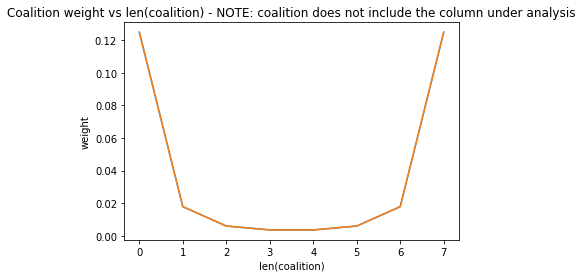

In [17]:
import math
tot_l = len(tmp.columns)
print(tot_l)
xx = [0, 1, 2, 3, 4, 5, 6, 7]
yy = [1 / (scipy.special.comb(tot_l - 2, x_tmp) * (tot_l-1)) for x_tmp in xx]
zz = [math.factorial(x_tmp) * math.factorial(tot_l - 2 - x_tmp) / math.factorial(tot_l - 1) for x_tmp in xx]
print(yy)
print(zz)
plt.plot(xx, yy, label='ori')
plt.plot(xx, zz, label='new')
plt.title('Coalition weight vs len(coalition) - NOTE: coalition does not include the column under analysis')
plt.xlabel('len(coalition)')
plt.ylabel('weight')
plt.show()

## Titanic con TEF-SHAP

In [18]:
# Lanzamos el script train+explain para titanic
phi0, shap_values =  main(tmp, tmp, state_dict={})

Training time: 0.021941423416137695
Progress: row 100
Progress: row 200
Progress: row 300
Progress: row 400
Progress: row 500
Progress: row 600
Progress: row 700
Progress: row 800
Progress: row 900
Progress: row 1000
Computation time: 51.563291788101196


In [19]:
# Comprobamos la calidad de la accuracy local
reconstr = np.round(phi0 + np.sum(shap_values, axis=1), 6)
print('Detected Target 1: {}'.format(sum(reconstr==1)))
print('Detected Target 0: {}'.format(sum(reconstr==0)))

count=0
eps_error = 0.000001
for i in range(len(tmp)):
    if abs(reconstr[i] - tmp.iloc[i]['target']) > eps_error:
        count += 1
print('Discrepancias (predicción modelo original != predicción SHAP) detectadas: {}'.format(count))

Detected Target 1: 343
Detected Target 0: 704
Discrepancias (predicción modelo original != predicción SHAP) detectadas: 0


**Explicabilidad global**

Para la explicabilidad global, usamos el mismo truco usado en la librería SHAP

explicabilidad global = mean(abs(explicabilidad local))

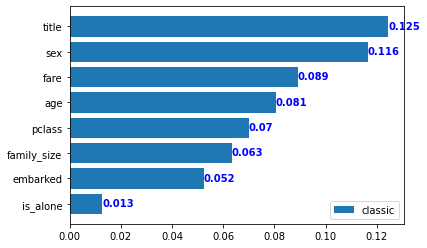

In [20]:
# Explicabilidad global
global_imp = np.abs(shap_values).mean(axis=0)

# Visualizamos los resultados
list1, list2 = zip(*sorted(zip(global_imp.tolist(), tmp.columns[:-1])))
plt.barh([c for c in list2], list1, label='classic')
for i, v in enumerate(list1):
    plt.text(v + 0.00, i - .1, str(round(v, 3)), color='blue', fontweight='bold')
#print(tmp.iloc[i])
plt.legend()
plt.show()

**Explicabilidad local**

Visualizamos algunos ejemplos

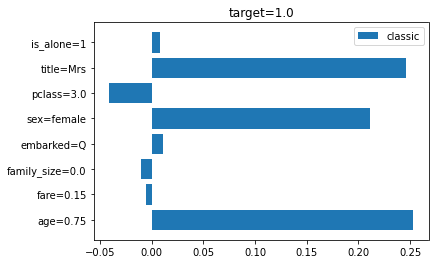

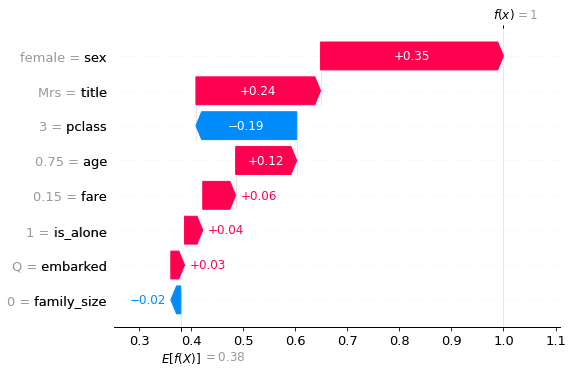

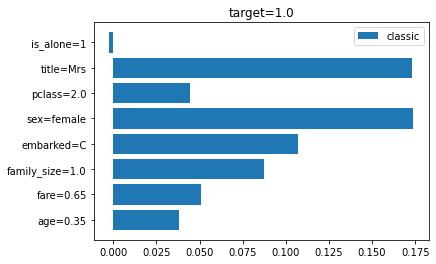

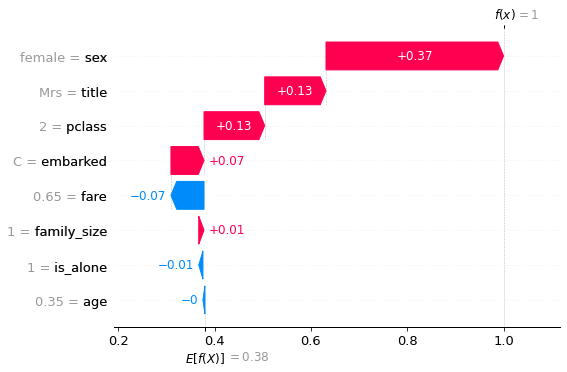

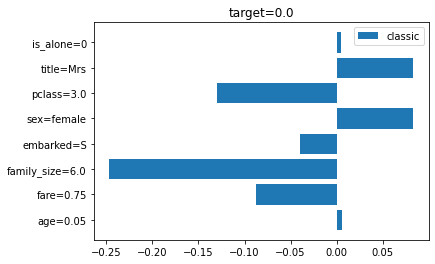

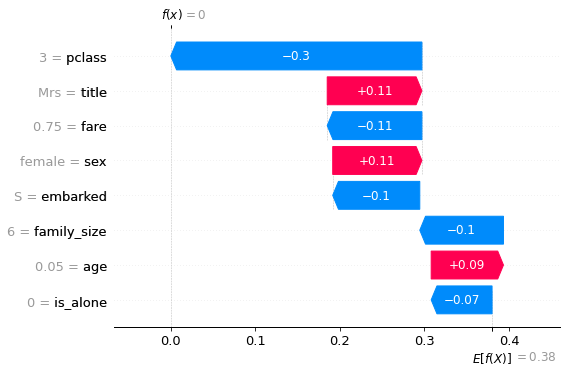

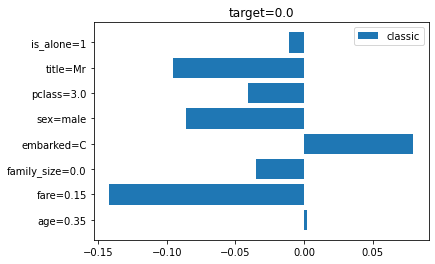

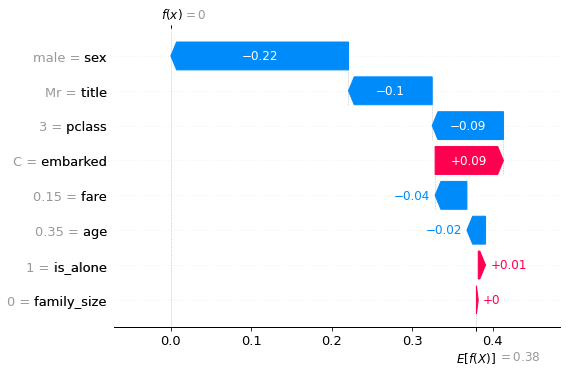

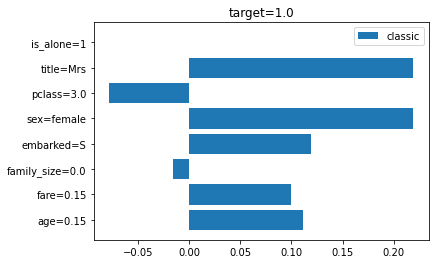

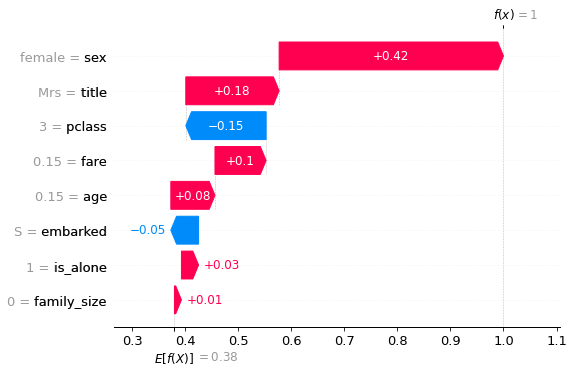

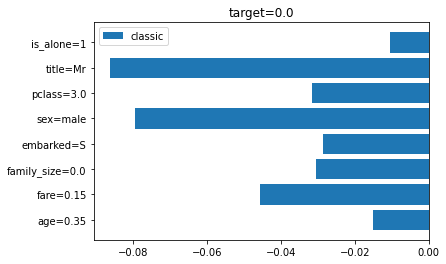

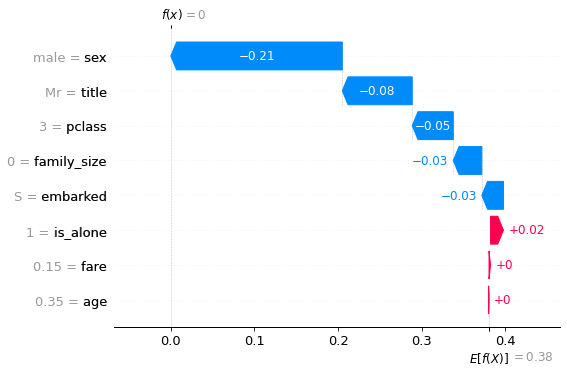

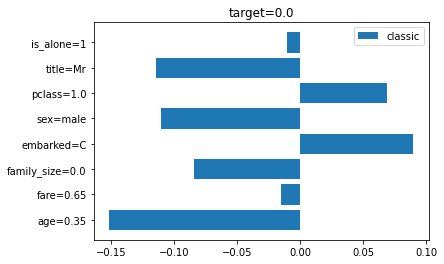

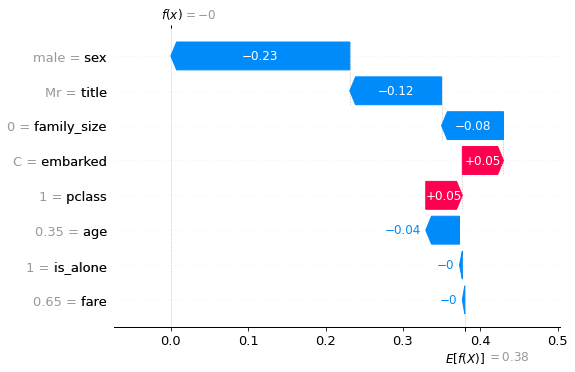

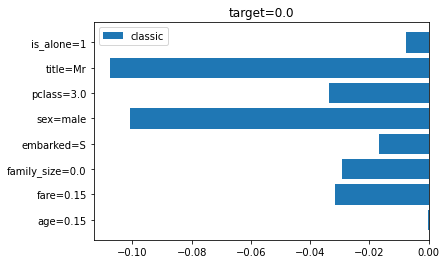

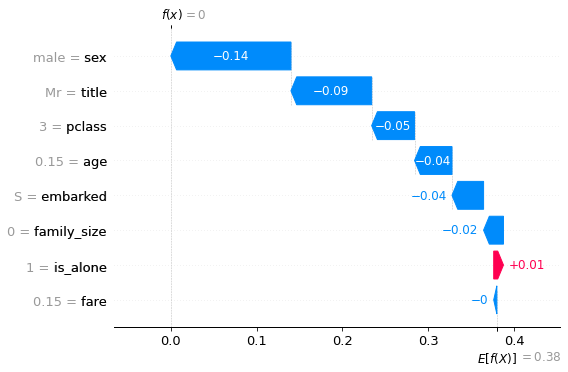

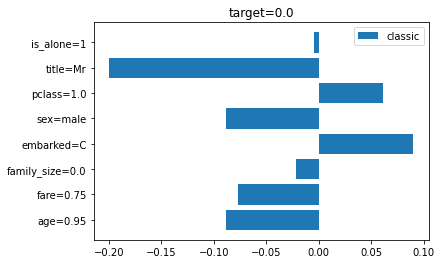

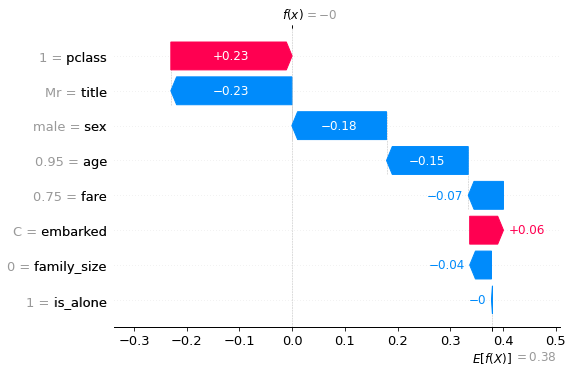

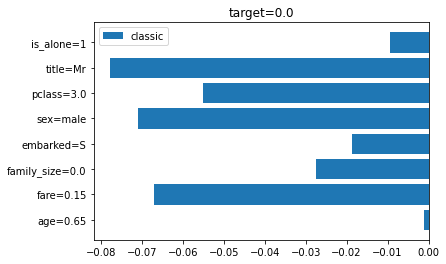

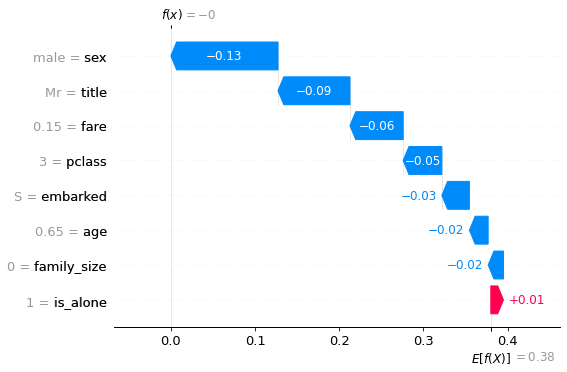

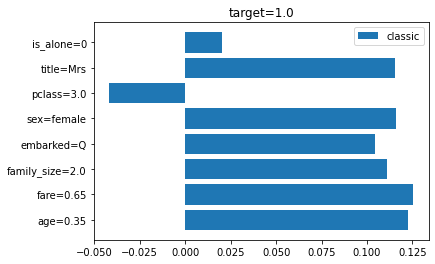

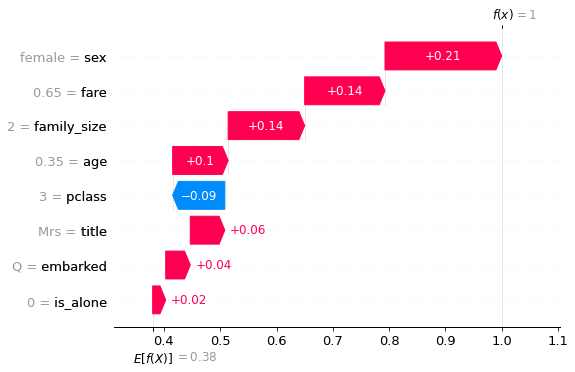

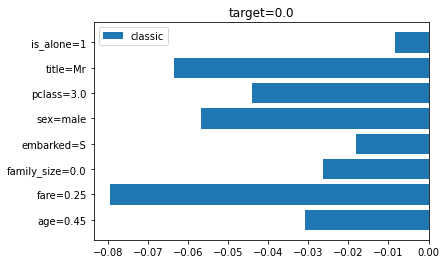

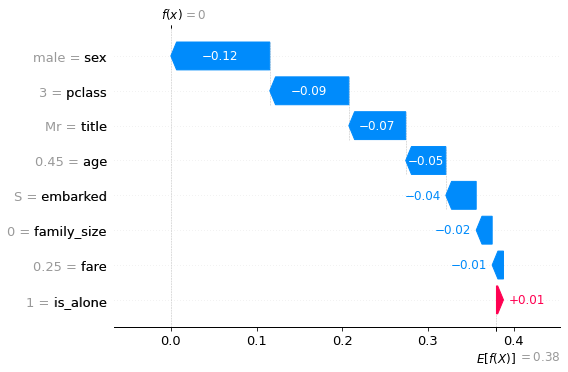

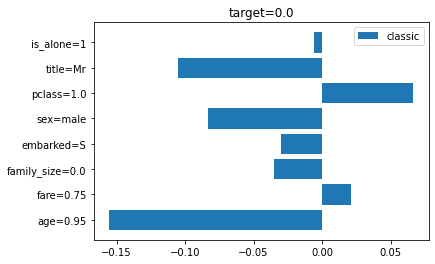

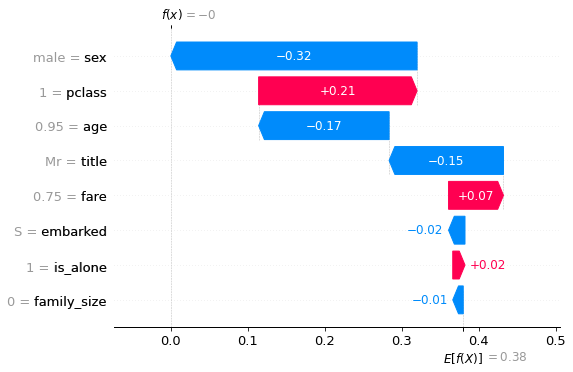

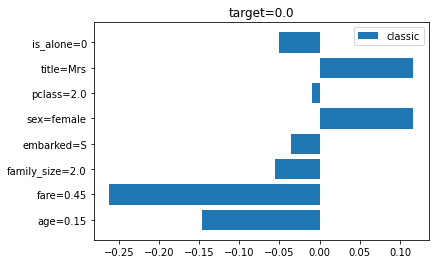

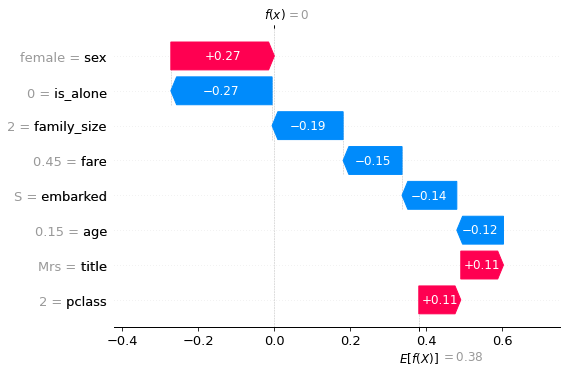

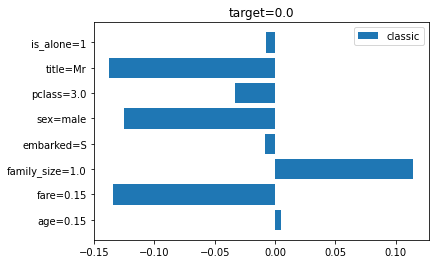

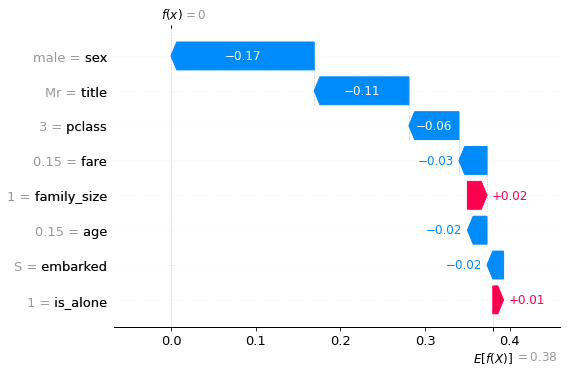

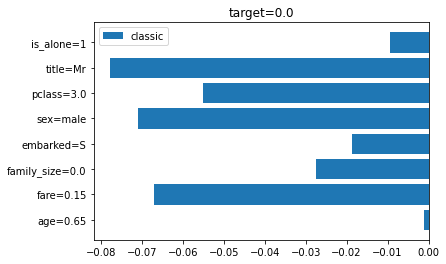

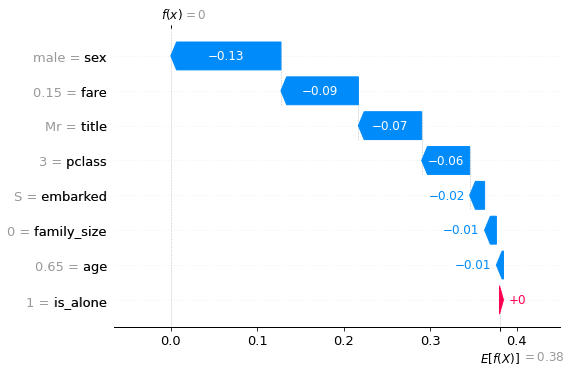

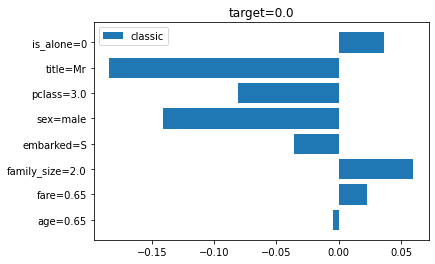

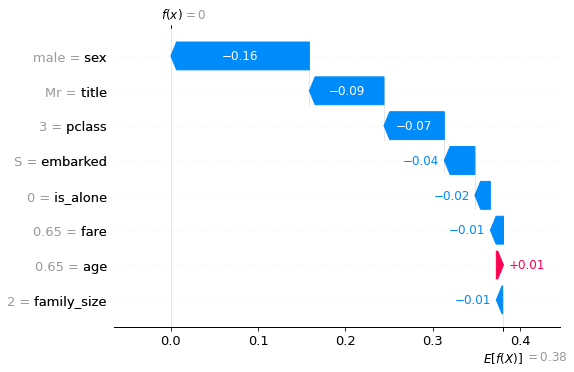

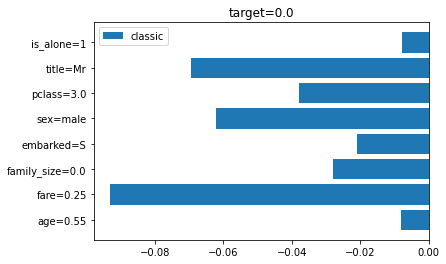

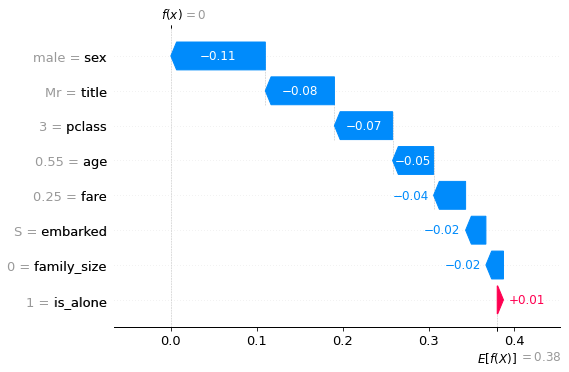

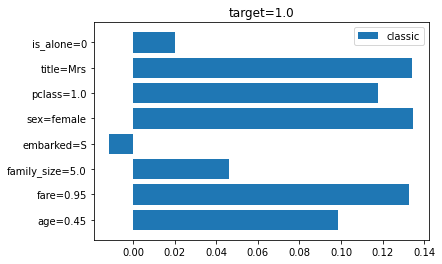

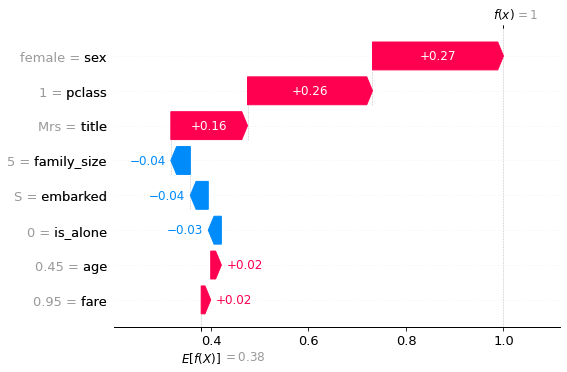

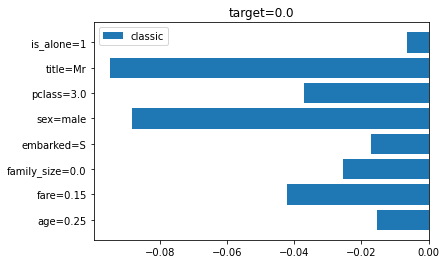

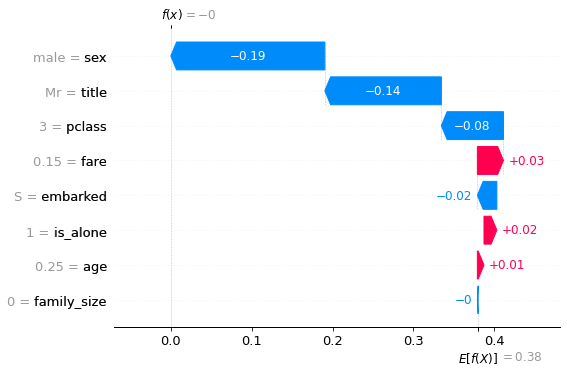

In [21]:
for i in range(20):
    plt.barh([c + '={}'.format(tmp.iloc[i][c]) for c in list(tmp.columns)[:-1]], shap_values[i,:], label='classic')
    plt.legend()
    plt.title('target={}'.format(tmp.iloc[i]['target']))
    plt.show()
    ShapExplainer.plot_shap_local_xai(shap_lib_values[i])    

# Análisis

Objetivo: mostrar como la correlación entre variables puede dificultar la interpretación de la explicabilidad local proporcionada por SHAP

Explicación: De forma naive, si dos features f1 y f2 correlan fortemente solo la explicación de f1+f2 (la suma de los Shapley Value de f1 y f2) tiene sentido.  Si f1 + f2 = K, lo importante es K como se reparte K entre f1 y f2 dependerá la implementación de SHap, de los datos utilizados para estimar la contribución de las coaliciones, etc.

Vamos a intentar ponerlo en evidencia mostrando como la explicabilidad obtenida por SHAP y TEF-SHAP es equivalente SOLO cuando se "agrupan/suman" las variables que correlan

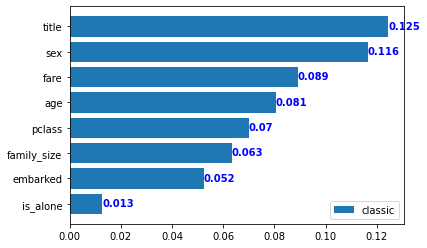

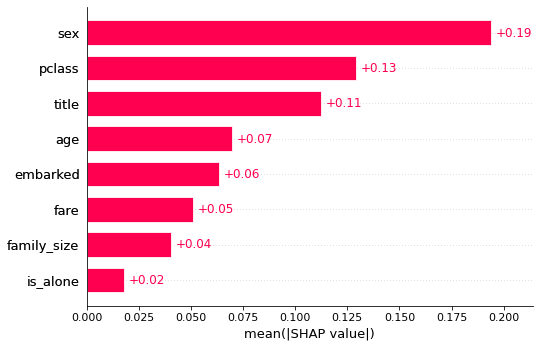

In [22]:
list1, list2 = zip(*sorted(zip(global_imp.tolist(), tmp.columns[:-1])))
plt.barh([c for c in list2], list1, label='classic')
for i, v in enumerate(list1):
    plt.text(v + 0.00, i - .1, str(round(v, 3)), color='blue', fontweight='bold')
#print(tmp.iloc[i])
plt.legend()
plt.show()

ShapExplainer.plot_shap_global_xai(shap_lib_values)

In [23]:
sorted_cols = ['sex', 'pclass', 'title', 'age', 'embarked', 'fare', 'family_size', 'is_alone']

### "Correlación" entre variables

In [24]:
import os as os
import pandas as pd
from itertools import product
import numpy as np
import scipy.stats as ss

In [25]:
cols = list(tmp.columns)[:-1]
cols1 = cols
cols2 = cols

cat_var_prod = list(product(cols1,cols2, repeat = 1))
print(len(cat_var_prod))

64


**Cramer v**

https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V

Código: https://github.com/shakedzy/dython

In [26]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

<AxesSubplot:xlabel='var2', ylabel='var1'>

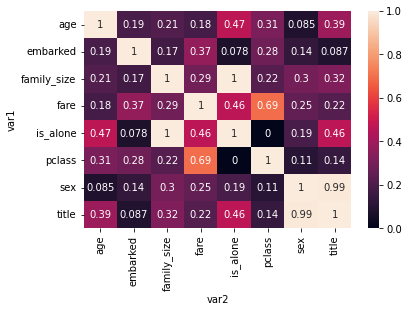

In [27]:
import seaborn as sns
c_result = []
for i in cat_var_prod:
    c_result.append((i[0],i[1],cramers_v(tmp[i[0]], tmp[i[1]])))
        
cramer_output = pd.DataFrame(c_result, columns = ['var1', 'var2', 'coeff'])
## Using pivot function to convert the above DataFrame into a crosstab
final_df = cramer_output.pivot(index='var1', columns='var2', values='coeff')

sns.heatmap(final_df, annot=True)

**Theils u**


https://en.wikipedia.org/wiki/Uncertainty_coefficient

Código: https://github.com/shakedzy/dython


In [28]:
import math
from collections import Counter

_REPLACE = "replace"
_DROP = "drop"
_DEFAULT_REPLACE_VALUE = 0.0

def replace_nan_with_value(x, y, value):
    x = np.array(
        [v if v == v and v is not None else value for v in x]
    )  # NaN != NaN
    y = np.array([v if v == v and v is not None else value for v in y])
    return x, y

def conditional_entropy(
    x,
    y,
    nan_strategy=_REPLACE,
    nan_replace_value=_DEFAULT_REPLACE_VALUE,
    log_base: float = math.e,
):
    """
    Calculates the conditional entropy of x given y: S(x|y)
    Wikipedia: https://en.wikipedia.org/wiki/Conditional_entropy
    Parameters:
    -----------
    x : list / NumPy ndarray / Pandas Series
        A sequence of measurements
    y : list / NumPy ndarray / Pandas Series
        A sequence of measurements
    nan_strategy : string, default = 'replace'
        How to handle missing values: can be either 'drop' to remove samples
        with missing values, or 'replace' to replace all missing values with
        the nan_replace_value. Missing values are None and np.nan.
    nan_replace_value : any, default = 0.0
        The value used to replace missing values with. Only applicable when
        nan_strategy is set to 'replace'.
    log_base: float, default = e
        specifying base for calculating entropy. Default is base e.
    Returns:
    --------
    float
    """
    if nan_strategy == _REPLACE:
        x, y = replace_nan_with_value(x, y, nan_replace_value)
    elif nan_strategy == _DROP:
        x, y = remove_incomplete_samples(x, y)
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x, y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y / p_xy, log_base)
    return entropy


def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

<AxesSubplot:xlabel='var2', ylabel='var1'>

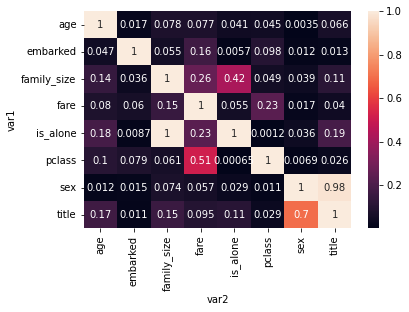

In [29]:
import seaborn as sns
t_result = []
for i in cat_var_prod:
    t_result.append((i[0],i[1],theils_u(tmp[i[0]], tmp[i[1]])))
        
theils_output = pd.DataFrame(t_result, columns = ['var1', 'var2', 'coeff'])
## Using pivot function to convert the above DataFrame into a crosstab
final_df = theils_output.pivot(index='var1', columns='var2', values='coeff')

sns.heatmap(final_df, annot=True)

**Chi2**

var2,age,embarked,family_size,fare,is_alone,pclass,sex,title
var1,,,,,,,,
age,NaN,7.891747e-13,4.919768e-56,2.139932e-41,6.027678e-46,2.224431e-36,5.551717e-02,2.446216e-88
embarked,7.891747e-13,NaN,2.070812e-10,7.851227e-54,1.580150e-02,6.976344e-35,2.564714e-05,1.326983e-03
family_size,4.919768e-56,2.070812e-10,NaN,5.826610e-119,1.066421e-220,2.490144e-18,1.840140e-18,3.554063e-59
fare,2.139932e-41,7.851227e-54,5.826610e-119,NaN,8.651780e-45,2.657921e-205,1.976614e-12,8.525417e-25
is_alone,6.027678e-46,1.580150e-02,1.066421e-220,8.651780e-45,NaN,5.074520e-01,2.793177e-10,7.222265e-49
pclass,2.224431e-36,6.976344e-35,2.490144e-18,2.657921e-205,5.074520e-01,NaN,7.252247e-04,5.759323e-09
sex,5.551717e-02,2.564714e-05,1.840140e-18,1.976614e-12,2.793177e-10,7.252247e-04,NaN,2.094058e-222
title,2.446216e-88,1.326983e-03,3.554063e-59,8.525417e-25,7.222265e-49,5.759323e-09,2.094058e-222,NaN


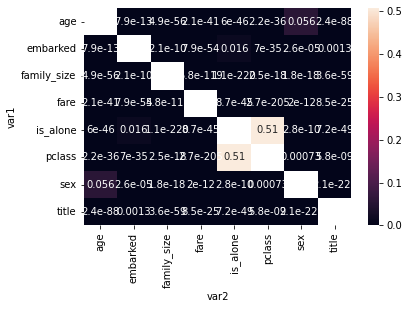

In [30]:
# Chi2
result = []
dofs = []
prob = 0.95
for i in cat_var_prod:
    if i[0] != i[1]:
        stat, p, dof, expected = list(ss.chi2_contingency(pd.crosstab(tmp[i[0]], tmp[i[1]])))
        #critical = ss.chi2.ppf(prob, dof)
        result.append((i[0],i[1],p))
        #result.append((i[0],i[1],abs(stat) > critical))
        dofs.append((i[0],i[1],dof))

chi_test_output = pd.DataFrame(result, columns = ['var1', 'var2', 'coeff'])
dof_chi_test_output = pd.DataFrame(dofs, columns = ['var1', 'var2', 'coeff'])
## Using pivot function to convert the above DataFrame into a crosstab
final_df = chi_test_output.pivot(index='var1', columns='var2', values='coeff')
sns.heatmap(final_df, annot=True)
final_df

In [31]:
# new_var1 = sex + title
# new_var2 = pclass + fare
# new_var3 = is_alone + family_size

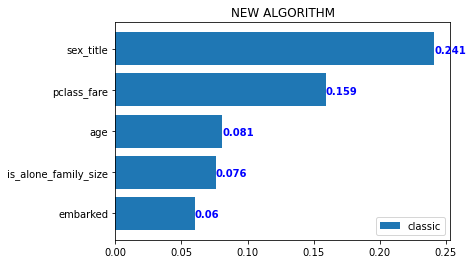

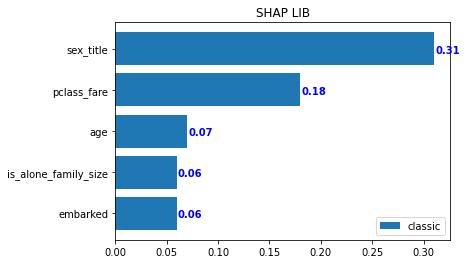

In [32]:
ours = [
    ['sex_title', 0.241],
    ['pclass_fare', 0.159],
    ['is_alone_family_size', 0.076],
    ['age', 0.081],
    ['embarked', 0.06]
]

shap_ref = [
    ['sex_title', 0.31],
    ['pclass_fare', 0.18],
    ['is_alone_family_size', 0.06],
    ['age', 0.07],
    ['embarked', 0.06]
]

listA, listB = zip(*ours)
listB, listA = zip(*sorted(zip(listB, listA)))
plt.barh([c for c in listA], listB, label='classic')
for i, v in enumerate(listB):
    plt.text(v + 0.00, i - .1, str(round(v, 3)), color='blue', fontweight='bold')
#print(tmp.iloc[i])
plt.legend()
plt.title('NEW ALGORITHM')
plt.show()

listA, listB = zip(*shap_ref)
listB, listA = zip(*sorted(zip(listB, listA)))
plt.barh([c for c in listA], listB, label='classic')
for i, v in enumerate(listB):
    plt.text(v + 0.001, i - .1, str(round(v, 3)), color='blue', fontweight='bold')
#print(tmp.iloc[i])
plt.legend()
plt.title('SHAP LIB')
plt.show()

## TEF-SHAP: PERMUTATION BASED ESTIMATION

Implementación para intentar escalar a > 20 columnas

**TODO**

## TEF-SHAP: REGRESSION BASED ESTIMATION

Implementación para intentar escalar a > 20 columnas

**TODO**